Simulation complete, time taken: 0.7212327998131514s


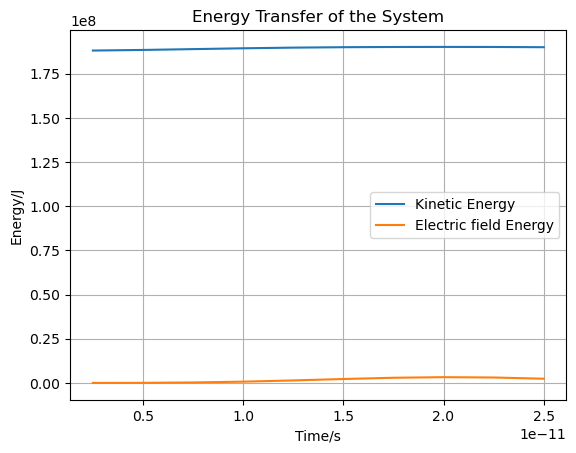

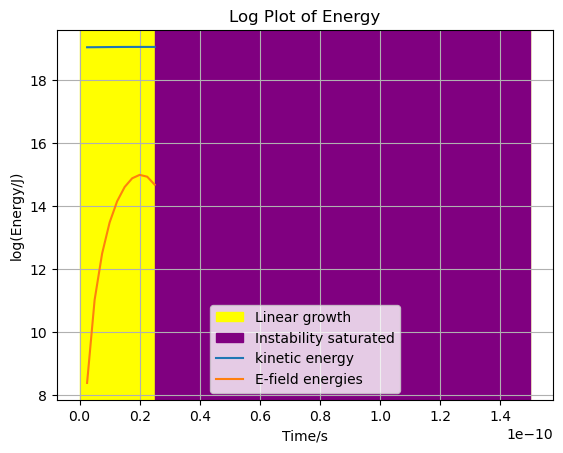

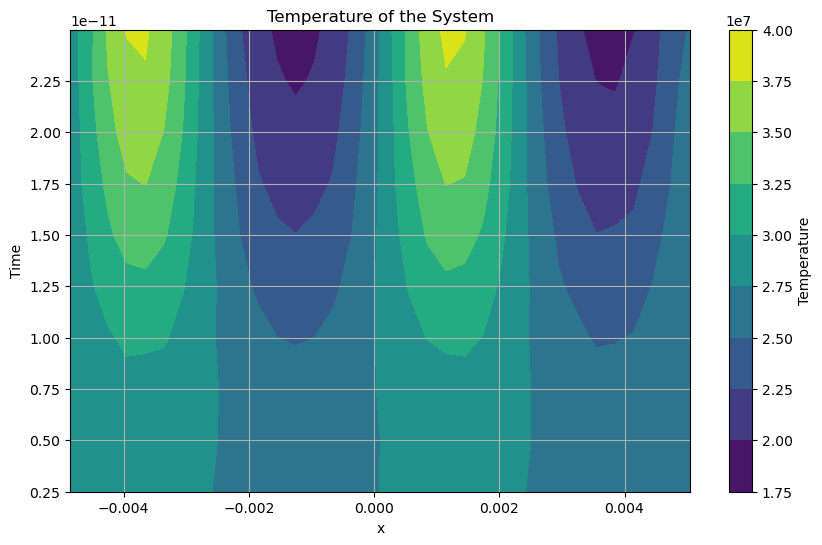

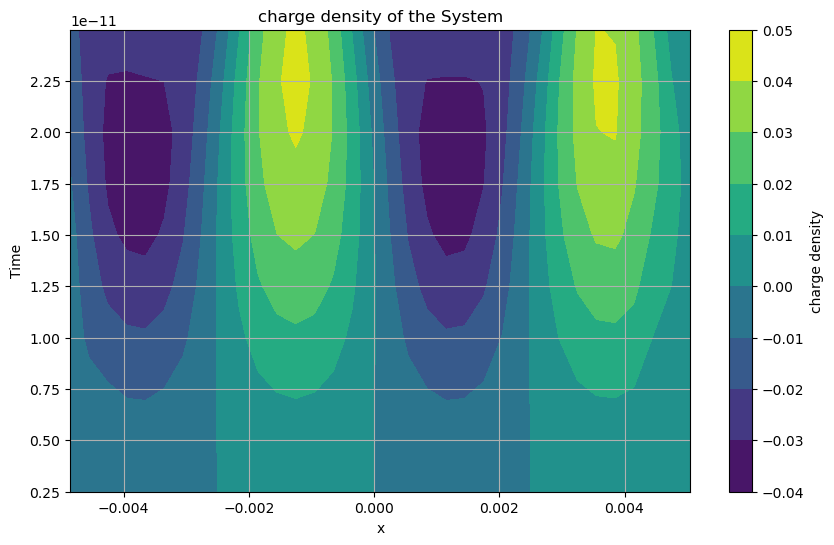

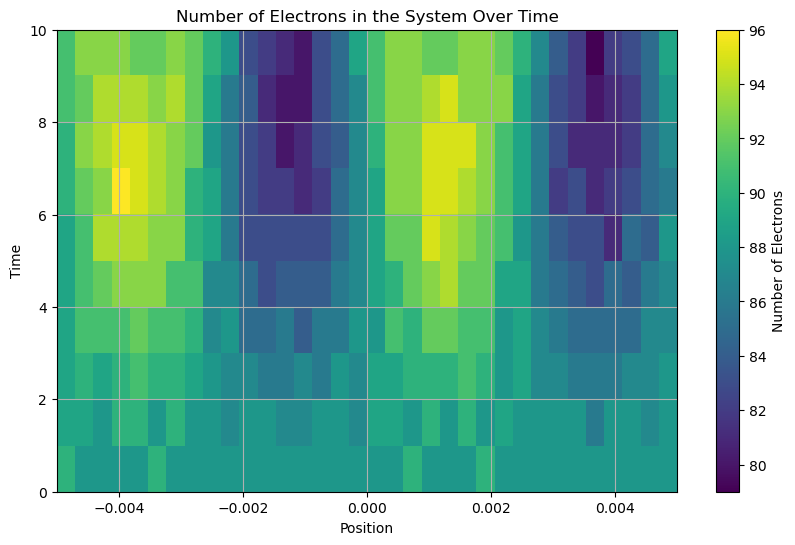

In [56]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 27 12:09:32 2023

@author: seanlim
"""

import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from simulation_module import simulation
import time

#Creating box and grid
box_size_x = 1e-2
box_size_y = 1e-2
box_size_z = 1e-2
box_size = (box_size_x,box_size_y,box_size_z)

dx=3e-4
grid = jnp.arange(-box_size_x/2+dx/2,box_size_x/2+dx/2,dx)
staggered_grid = grid + dx/2

#Creating particle ICs
no_pseudoelectrons = 3000
L= box_size_x
xs = jnp.array([jnp.linspace(-L/2,L/2,no_pseudoelectrons)])
seed = 1701
key = jax.random.PRNGKey(seed)
electron_ys = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_y/2,maxval=box_size_y/2)
electron_zs = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_z/2,maxval=box_size_z/2)
electron_xs_array = jnp.transpose(jnp.concatenate((xs,electron_ys,electron_zs)))
#%%
'Electron-electron stream with stationary ions'
ion_ys = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_y/2,maxval=box_size_y/2)
ion_zs = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_z/2,maxval=box_size_z/2)
ion_xs_array = jnp.transpose(jnp.concatenate((xs,ion_ys,ion_zs)))

particle_xs_array = jnp.concatenate((electron_xs_array,ion_xs_array))
no_pseudoparticles = len(particle_xs_array)

alternating_ones = (-1)**jnp.array(range(0,no_pseudoelectrons))
v0=0.5e8
electron_vxs = v0*alternating_ones
ion_vxs = jnp.zeros(no_pseudoelectrons)
vxs = jnp.concatenate((electron_vxs,ion_vxs))
vys = jnp.zeros(no_pseudoparticles)
vzs = jnp.zeros(no_pseudoparticles)
particle_vs_array = jnp.transpose(jnp.concatenate((jnp.array([vxs]),jnp.array([vys]),jnp.array([vzs]))))

weight = 1e13
q_es = -1.6e-19*weight*jnp.ones(shape=(no_pseudoelectrons,1))
q_ps = 1.6e-19*weight*jnp.ones(shape=(no_pseudoelectrons,1))
qs = jnp.concatenate((q_es,q_ps))
m_es = 9.1e-31*weight*jnp.ones(shape=(no_pseudoelectrons,1))
m_ps = 1.67e-27*weight*jnp.ones(shape=(no_pseudoelectrons,1))
ms = jnp.concatenate((m_es,m_ps))
q_mes = -1.76e11*jnp.ones(shape=(no_pseudoelectrons,1))
q_mps = 9.56e7*jnp.ones(shape=(no_pseudoelectrons,1))
q_ms = jnp.concatenate((q_mes,q_mps))

particles = (particle_xs_array,particle_vs_array,qs,ms,q_ms,
             (no_pseudoelectrons,no_pseudoparticles-no_pseudoelectrons),
             weight)

#Creating initial fields
E_fields = jnp.zeros(shape=(len(grid),3))
B_fields = jnp.zeros(shape=(len(grid),3))

fields = (E_fields,B_fields)

ICs = (box_size,particles,fields)

x=[0.1,1256]
A=x[0]
k=x[1]
ext_E = jnp.zeros(shape=(len(grid),3))
for i in range(len(grid)):
    ext_E = ext_E.at[i].set(jnp.array(
        [-weight*1.6e-19*no_pseudoelectrons*A*jnp.cos(k*(grid[i]+dx/2))/(k*L*8.85e-12),0,0])
        )
        
ext_B = jnp.zeros(shape=(len(grid),3))
ext_fields = (ext_E,ext_B)
#%%
#Simulation
dt = dx/(2*3e8)
steps_per_snapshots=5
total_steps=50

start = time.perf_counter()
Data = simulation(steps_per_snapshots,total_steps,ICs,ext_fields,dx,dt,(0,0,0,0))
end = time.perf_counter()
print('Simulation complete, time taken: '+str(end-start)+'s')

t = jnp.array(Data['Time'])
#%%
xs_over_time = jnp.array(Data['Positions'])
vs_over_time = jnp.array(Data['Velocities'])

ke_over_time = jnp.array(Data['Kinetic Energy'])
E_field_energy_density = jnp.array(Data['E-field Energy'])
E_field_energy = jnp.sum(E_field_energy_density,axis=1)
plt.title('Energy Transfer of the System')
plt.ylabel('Energy/J')
plt.xlabel('Time/s')
plt.plot(t,ke_over_time,label='Kinetic Energy')
plt.plot(t,E_field_energy,label='Electric field Energy')
plt.grid()
plt.legend()
plt.show()
#%%
plt.title('Log Plot of Energy')
plt.axvspan(0,1.5e-10,color='yellow',label='Linear growth')
plt.axvspan(1.5e-10,t[-1],color='purple',label='Instability saturated')
plt.xlabel('Time/s')
plt.ylabel('log(Energy/J)')
plt.plot(t,jnp.log(ke_over_time),label='kinetic energy')
plt.plot(t,jnp.log(E_field_energy),label='E-field energies')
plt.grid()
plt.legend()
plt.show()

Ts_over_time = jnp.array(Data['Temperature'])

# Extracting the shape of the data
time_steps, _, positions = Ts_over_time.shape
# Create a meshgrid for time and position
time = jnp.arange(time_steps)
position = jnp.arange(positions)
time_mesh, position_mesh = jnp.meshgrid(t, grid, indexing='ij')

# Extracting temperature values
temperature_values = Ts_over_time[:, 0, :]

# Plotting the density plot
plt.figure(figsize=(10, 6))
plt.contourf(position_mesh, time_mesh, temperature_values, cmap='viridis')
plt.colorbar(label='Temperature')
plt.title('Temperature of the System')
plt.xlabel('x')
plt.ylabel('Time')
plt.grid(True)
plt.show()

density = jnp.array(Data['Charge Densities'])

# Plotting the density plot
plt.figure(figsize=(10, 6))
plt.contourf(position_mesh, time_mesh, density, cmap='viridis')
plt.colorbar(label='charge density')
plt.title('charge density of the System')
plt.xlabel('x')
plt.ylabel('Time')
plt.grid(True)
plt.show()

xs_over_time = jnp.array(Data['Positions'])
# Define the bin edges for histogram (based on box size and grid size)
bin_edges = jnp.linspace(-box_size_x/2,box_size_x/2,len(grid)+1)

# Initialize an array to store the histogram counts over time
hist_counts = jnp.zeros((time_steps, len(grid)))

# Calculate the histogram for each time step
for t in range(time_steps):
    counts, _ = jnp.histogram(xs_over_time[t, :no_pseudoelectrons, 0], bins=bin_edges)
    hist_counts = hist_counts.at[t].set(counts)


# Plotting the density plot with time on the y-axis
plt.figure(figsize=(10, 6))
plt.imshow(hist_counts, aspect='auto', cmap='viridis', origin='lower',
           extent=[-box_size_x / 2, box_size_x / 2, 0, time_steps])
plt.colorbar(label='Number of Electrons')
plt.title('Number of Electrons in the System Over Time')
plt.xlabel('Position')
plt.ylabel('Time')
plt.grid(True)
plt.show()
plt.show()

Simulation complete, time taken: 0.3204029002226889s


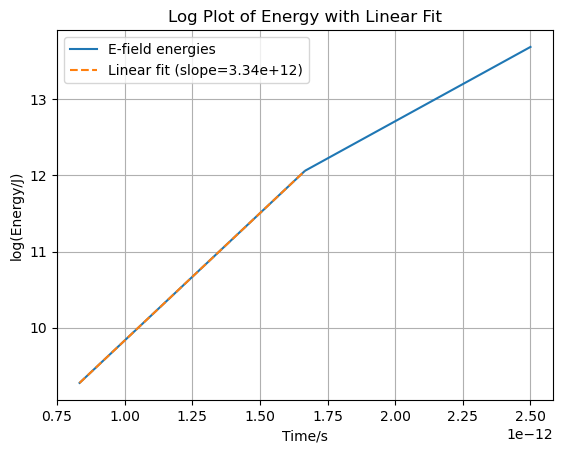

3343184713225.7686


In [13]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 27 12:09:32 2023

@author: seanlim
"""

import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from simulation_module import simulation
import time

#Creating box and grid
box_size_x = 1e-2
box_size_y = 1e-2
box_size_z = 1e-2
box_size = (box_size_x,box_size_y,box_size_z)

dx=1e-4
grid = jnp.arange(-box_size_x/2+dx/2,box_size_x/2+dx/2,dx)
staggered_grid = grid + dx/2

#Creating particle ICs
no_pseudoelectrons = 3000
L= box_size_x
xs = jnp.array([jnp.linspace(-L/2,L/2,no_pseudoelectrons)])
seed = 1701
key = jax.random.PRNGKey(seed)
electron_ys = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_y/2,maxval=box_size_y/2)
electron_zs = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_z/2,maxval=box_size_z/2)
electron_xs_array = jnp.transpose(jnp.concatenate((xs,electron_ys,electron_zs)))
#%%
'Electron-electron stream with stationary ions'
ion_ys = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_y/2,maxval=box_size_y/2)
ion_zs = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_z/2,maxval=box_size_z/2)
ion_xs_array = jnp.transpose(jnp.concatenate((xs,ion_ys,ion_zs)))

particle_xs_array = jnp.concatenate((electron_xs_array,ion_xs_array))
no_pseudoparticles = len(particle_xs_array)

alternating_ones = (-1)**jnp.array(range(0,no_pseudoelectrons))
v0=0.5e8
electron_vxs = v0*alternating_ones
ion_vxs = jnp.zeros(no_pseudoelectrons)
vxs = jnp.concatenate((electron_vxs,ion_vxs))
vys = jnp.zeros(no_pseudoparticles)
vzs = jnp.zeros(no_pseudoparticles)
particle_vs_array = jnp.transpose(jnp.concatenate((jnp.array([vxs]),jnp.array([vys]),jnp.array([vzs]))))

weight = 1e13
q_es = -1.6e-19*weight*jnp.ones(shape=(no_pseudoelectrons,1))
q_ps = 1.6e-19*weight*jnp.ones(shape=(no_pseudoelectrons,1))
qs = jnp.concatenate((q_es,q_ps))
m_es = 9.1e-31*weight*jnp.ones(shape=(no_pseudoelectrons,1))
m_ps = 1.67e-27*weight*jnp.ones(shape=(no_pseudoelectrons,1))
ms = jnp.concatenate((m_es,m_ps))
q_mes = -1.76e11*jnp.ones(shape=(no_pseudoelectrons,1))
q_mps = 9.56e7*jnp.ones(shape=(no_pseudoelectrons,1))
q_ms = jnp.concatenate((q_mes,q_mps))

particles = (particle_xs_array,particle_vs_array,qs,ms,q_ms,
             (no_pseudoelectrons,no_pseudoparticles-no_pseudoelectrons),
             weight)

#Creating initial fields
#Creating initial fields
E_fields = jnp.zeros(shape=(len(grid),3))
B_fields = jnp.zeros(shape=(len(grid),3))

fields = (E_fields,B_fields)

ICs = (box_size,particles,fields)

x=[0.5,1256]
A=x[0]
k=x[1]
ext_E = jnp.zeros(shape=(len(grid),3))
for i in range(len(grid)):
    ext_E = ext_E.at[i].set(jnp.array(
        [-weight*1.6e-19*no_pseudoelectrons*A*jnp.cos(k*(grid[i]+dx/2))/(k*L*8.85e-12),0,0])
        )
        
ext_B = jnp.zeros(shape=(len(grid),3))
ext_fields = (ext_E,ext_B)
#%%
#Simulation
dt = dx/(2*3e8)
steps_per_snapshots=5
total_steps=15

start = time.perf_counter()
Data = simulation(steps_per_snapshots,total_steps,ICs,ext_fields,dx,dt,(0,0,0,0))
end = time.perf_counter()
print('Simulation complete, time taken: '+str(end-start)+'s')

t = jnp.array(Data['Time'])
E_field_energy_density = jnp.array(Data['E-field Energy'])
E_field_energy = jnp.sum(E_field_energy_density,axis=1)

# Compute the log of E-field energy
log_E_field_energy = jnp.log(E_field_energy)

# Sliding window parameters
window_size = 2  # Adjust window size based on data resolution
r2_threshold = 0.8  # Adjust threshold based on desired fit quality

# Calculate R² for each window
r2_values = []
for i in range(len(t) - window_size):
    window_t = t[i:i + window_size]
    window_log_E = log_E_field_energy[i:i + window_size]
    slope, intercept, r_value, p_value, std_err = linregress(window_t, window_log_E)
    r2_values.append(r_value**2)

# Identify the transition index
transition_index = np.argmax(np.array(r2_values) < r2_threshold) + window_size

# Ensure the transition index is within the valid range
transition_index = min(transition_index, len(t) - 1)

# Extract the linear growth region
linear_t = t[:transition_index]
linear_log_E_field_energy = log_E_field_energy[:transition_index]

# Perform linear regression on the linear growth region
slope, intercept, r_value, p_value, std_err = linregress(linear_t, linear_log_E_field_energy)

# Generate fitted values
fitted_log_E_field_energy = slope * linear_t + intercept

# Plot original log energy data and the fitted line
plt.figure()
plt.title('Log Plot of Energy with Linear Fit')
plt.xlabel('Time/s')
plt.ylabel('log(Energy/J)')
plt.plot(t, log_E_field_energy, label='E-field energies')
plt.plot(linear_t, fitted_log_E_field_energy, label=f'Linear fit (slope={slope:.2e})', linestyle='--')
plt.grid()
plt.legend()
plt.show()
print(slope)



In [2]:


import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from simulation_module import simulation
import time
import scipy
import matplotlib.pyplot as plt
import jaxopt
import optax
from scipy.signal import find_peaks
import pandas as pd
import os

#Creating box and grid
box_size_x = 1e-2
box_size_y = 1e-2
box_size_z = 1e-2
box_size = (box_size_x,box_size_y,box_size_z)

dx=3e-4
grid = jnp.arange(-box_size_x/2+dx/2,box_size_x/2+dx/2,dx)
staggered_grid = grid + dx/2

#Creating particle ICs
no_pseudoelectrons = 3000
L= box_size_x
xs = jnp.array([jnp.linspace(-L/2,L/2,no_pseudoelectrons)])
seed = 1701
key = jax.random.PRNGKey(seed)
electron_ys = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_y/2,maxval=box_size_y/2)
electron_zs = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_z/2,maxval=box_size_z/2)
electron_xs_array = jnp.transpose(jnp.concatenate((xs,electron_ys,electron_zs)))
#%%
'Electron-electron stream with stationary ions'
ion_ys = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_y/2,maxval=box_size_y/2)
ion_zs = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_z/2,maxval=box_size_z/2)
ion_xs_array = jnp.transpose(jnp.concatenate((xs,ion_ys,ion_zs)))

particle_xs_array = jnp.concatenate((electron_xs_array,ion_xs_array))
no_pseudoparticles = len(particle_xs_array)

alternating_ones = (-1)**jnp.array(range(0,no_pseudoelectrons))
v0=0.5e8
electron_vxs = v0*alternating_ones
ion_vxs = jnp.zeros(no_pseudoelectrons)
vxs = jnp.concatenate((electron_vxs,ion_vxs))
vys = jnp.zeros(no_pseudoparticles)
vzs = jnp.zeros(no_pseudoparticles)
particle_vs_array = jnp.transpose(jnp.concatenate((jnp.array([vxs]),jnp.array([vys]),jnp.array([vzs]))))

weight = 1e13
q_es = -1.6e-19*weight*jnp.ones(shape=(no_pseudoelectrons,1))
q_ps = 1.6e-19*weight*jnp.ones(shape=(no_pseudoelectrons,1))
qs = jnp.concatenate((q_es,q_ps))
m_es = 9.1e-31*weight*jnp.ones(shape=(no_pseudoelectrons,1))
m_ps = 1.67e-27*weight*jnp.ones(shape=(no_pseudoelectrons,1))
ms = jnp.concatenate((m_es,m_ps))
q_mes = -1.76e11*jnp.ones(shape=(no_pseudoelectrons,1))
q_mps = 9.56e7*jnp.ones(shape=(no_pseudoelectrons,1))
q_ms = jnp.concatenate((q_mes,q_mps))

particles = (particle_xs_array,particle_vs_array,qs,ms,q_ms,
             (no_pseudoelectrons,no_pseudoparticles-no_pseudoelectrons),
             weight)

#Creating initial fields
#Creating initial fields
E_fields = jnp.zeros(shape=(len(grid),3))
B_fields = jnp.zeros(shape=(len(grid),3))

fields = (E_fields,B_fields)

ICs = (box_size,particles,fields)

def func(x):
    A=x
    k=1256
    ext_E = jnp.zeros(shape=(len(grid),3))
    for i in range(len(grid)):
        ext_E = ext_E.at[i].set(jnp.array(
            [-weight*1.6e-19*no_pseudoelectrons*A*jnp.cos(k*(grid[i]+dx/2))/(k*L*8.85e-12),0,0])
            )
        
    ext_B = jnp.zeros(shape=(len(grid),3))
    ext_fields = (ext_E,ext_B)

    #Simulation
    dt = dx/(2*3e8)
    steps_per_snapshots=5
    total_steps=15

    start = time.perf_counter()
    Data = simulation(steps_per_snapshots,total_steps,ICs,ext_fields,dx,dt,(0,0,0,0))
    end = time.perf_counter()
    print('Simulation complete, time taken: '+str(end-start)+'s')

    t = jnp.array(Data['Time'])
    E_field_energy_density = jnp.array(Data['E-field Energy'])
    E_field_energy = jnp.sum(E_field_energy_density,axis=1)

    # Compute the log of E-field energy
    log_E_field_energy = jnp.log(E_field_energy)

    # Sliding window parameters
    window_size = 2  # Adjust window size based on data resolution
    r2_threshold = 0.8  # Adjust threshold based on desired fit quality

    # Calculate R² for each window
    r2_values = []
    for i in range(len(t) - window_size):
        window_t = t[i:i + window_size]
        window_log_E = log_E_field_energy[i:i + window_size]
        slope, intercept, r_value, p_value, std_err = linregress(window_t, window_log_E)
        r2_values.append(r_value**2)

    # Identify the transition index
    transition_index = np.argmax(np.array(r2_values) < r2_threshold) + window_size

    # Ensure the transition index is within the valid range
    transition_index = min(transition_index, len(t) - 1)

    # Extract the linear growth region
    linear_t = t[:transition_index]
    linear_log_E_field_energy = log_E_field_energy[:transition_index]

    # Perform linear regression on the linear growth region
    slope, intercept, r_value, p_value, std_err = linregress(linear_t, linear_log_E_field_energy)

    return slope

# Define the range of values for A and k
A_values = jnp.linspace(0, 1, 50)

for i in range(len(A_values)):

        # Append the data to the list
        data = {
            'A': A_values[i],
            'growth': func(A_values[i])
        }

        # Convert the dictionary to a DataFrame
        df = pd.DataFrame([data])

        # File path
        file_path = 'D:\\Desktop\\code\\PiC-Code-Jax\\new\\initail_rate_fit.csv'

        # Check if file exists
        if os.path.exists(file_path):
            # If file exists, append data without writing the header
            df.to_csv(file_path, mode='a', header=False, index=False)
        else:
            # If file does not exist, create it and write the data with the header
            df.to_csv(file_path, mode='w', header=True, index=False)

        print(f"Data saved to {file_path}")


Simulation complete, time taken: 15.924463999923319s
Data saved to D:\Desktop\code\PiC-Code-Jax\new\initail_rate_fit.csv
Simulation complete, time taken: 0.24801059998571873s
Data saved to D:\Desktop\code\PiC-Code-Jax\new\initail_rate_fit.csv
Simulation complete, time taken: 0.23358770040795207s
Data saved to D:\Desktop\code\PiC-Code-Jax\new\initail_rate_fit.csv
Simulation complete, time taken: 0.24081330001354218s
Data saved to D:\Desktop\code\PiC-Code-Jax\new\initail_rate_fit.csv
Simulation complete, time taken: 0.2276677000336349s
Data saved to D:\Desktop\code\PiC-Code-Jax\new\initail_rate_fit.csv
Simulation complete, time taken: 0.22861370025202632s
Data saved to D:\Desktop\code\PiC-Code-Jax\new\initail_rate_fit.csv
Simulation complete, time taken: 0.21861730003729463s
Data saved to D:\Desktop\code\PiC-Code-Jax\new\initail_rate_fit.csv
Simulation complete, time taken: 0.20933419978246093s
Data saved to D:\Desktop\code\PiC-Code-Jax\new\initail_rate_fit.csv
Simulation complete, time 

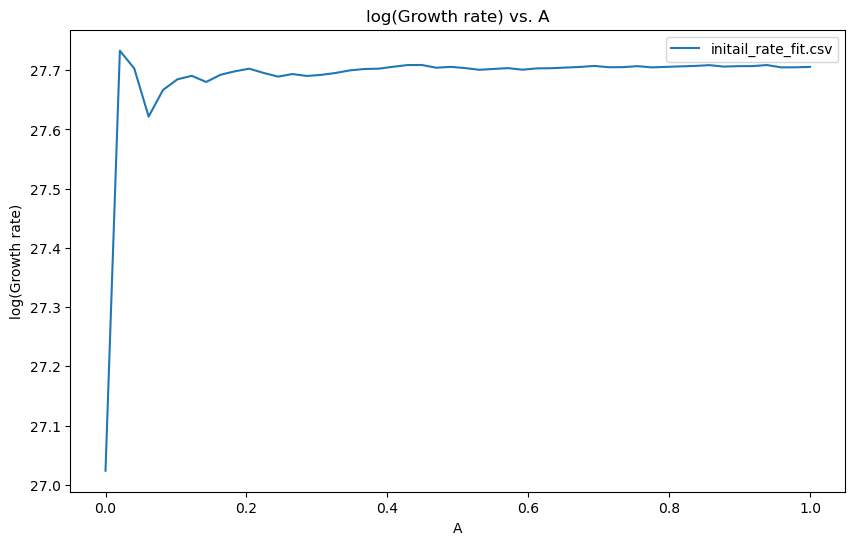

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the directory containing the files
file_directory = 'D:\\Desktop\\code\\PiC-Code-Jax\\new\\'

# List of file names
file_names = ['initail_rate_fit.csv']

# Initialize the plot
plt.figure(figsize=(10, 6))

# Iterate over each file
for file_name in file_names:
    file_path = os.path.join(file_directory, file_name)
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Plot the data
        plt.plot(df['A'], np.log(df['growth']), label=file_name)
    else:
        print(f"File {file_path} does not exist.")

# Add title and labels
plt.title('log(Growth rate) vs. A')
plt.xlabel('A')
plt.ylabel('log(Growth rate)')
plt.legend()

# Display the plot
plt.show()


In [57]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from simulation_module import simulation
import time
import scipy
import matplotlib.pyplot as plt
import jaxopt
import optax
from scipy.signal import find_peaks
import pandas as pd
import os

#Creating box and grid
box_size_x = 1e-2
box_size_y = 1e-2
box_size_z = 1e-2
box_size = (box_size_x,box_size_y,box_size_z)

dx=3e-4
grid = jnp.arange(-box_size_x/2+dx/2,box_size_x/2+dx/2,dx)
staggered_grid = grid + dx/2

#Creating particle ICs
no_pseudoelectrons = 3000
L= box_size_x
xs = jnp.array([jnp.linspace(-L/2,L/2,no_pseudoelectrons)])
seed = 1701
key = jax.random.PRNGKey(seed)
electron_ys = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_y/2,maxval=box_size_y/2)
electron_zs = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_z/2,maxval=box_size_z/2)
electron_xs_array = jnp.transpose(jnp.concatenate((xs,electron_ys,electron_zs)))
#%%
'Electron-electron stream with stationary ions'
ion_ys = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_y/2,maxval=box_size_y/2)
ion_zs = jax.random.uniform(key,shape=(1,no_pseudoelectrons),minval=-box_size_z/2,maxval=box_size_z/2)
ion_xs_array = jnp.transpose(jnp.concatenate((xs,ion_ys,ion_zs)))

particle_xs_array = jnp.concatenate((electron_xs_array,ion_xs_array))
no_pseudoparticles = len(particle_xs_array)

alternating_ones = (-1)**jnp.array(range(0,no_pseudoelectrons))
v0=0.5e8
electron_vxs = v0*alternating_ones
ion_vxs = jnp.zeros(no_pseudoelectrons)
vxs = jnp.concatenate((electron_vxs,ion_vxs))
vys = jnp.zeros(no_pseudoparticles)
vzs = jnp.zeros(no_pseudoparticles)
particle_vs_array = jnp.transpose(jnp.concatenate((jnp.array([vxs]),jnp.array([vys]),jnp.array([vzs]))))

weight = 1e13
q_es = -1.6e-19*weight*jnp.ones(shape=(no_pseudoelectrons,1))
q_ps = 1.6e-19*weight*jnp.ones(shape=(no_pseudoelectrons,1))
qs = jnp.concatenate((q_es,q_ps))
m_es = 9.1e-31*weight*jnp.ones(shape=(no_pseudoelectrons,1))
m_ps = 1.67e-27*weight*jnp.ones(shape=(no_pseudoelectrons,1))
ms = jnp.concatenate((m_es,m_ps))
q_mes = -1.76e11*jnp.ones(shape=(no_pseudoelectrons,1))
q_mps = 9.56e7*jnp.ones(shape=(no_pseudoelectrons,1))
q_ms = jnp.concatenate((q_mes,q_mps))

particles = (particle_xs_array,particle_vs_array,qs,ms,q_ms,
             (no_pseudoelectrons,no_pseudoparticles-no_pseudoelectrons),
             weight)

#Creating initial fields
#Creating initial fields
E_fields = jnp.zeros(shape=(len(grid),3))
B_fields = jnp.zeros(shape=(len(grid),3))

fields = (E_fields,B_fields)

ICs = (box_size,particles,fields)

def func(x):
    A=x
    k=1256
    ext_E = jnp.zeros(shape=(len(grid),3))
    for i in range(len(grid)):
        ext_E = ext_E.at[i].set(jnp.array(
            [-weight*1.6e-19*no_pseudoelectrons*A*jnp.cos(k*(grid[i]+dx/2))/(k*L*8.85e-12),0,0])
            )
        
    ext_B = jnp.zeros(shape=(len(grid),3))
    ext_fields = (ext_E,ext_B)

    #Simulation
    dt = dx/(2*3e8)
    steps_per_snapshots=5
    total_steps=15

    start = time.perf_counter()
    Data = simulation(steps_per_snapshots,total_steps,ICs,ext_fields,dx,dt,(0,0,0,0))
    end = time.perf_counter()
    print('Simulation complete, time taken: '+str(end-start)+'s')

    t = jnp.array(Data['Time'])
    E_field_energy_density = jnp.array(Data['E-field Energy'])
    E_field_energy = jnp.sum(E_field_energy_density,axis=1)
    slope=E_field_energy[total_steps-1]/((total_steps)*dt)

    return slope

# Define the range of values for A and k
A_values = jnp.linspace(0, 1, 50)

for i in range(len(A_values)):

        # Append the data to the list
        data = {
            'A': A_values[i],
            'growth': func(A_values[i])
        }

        # Convert the dictionary to a DataFrame
        df = pd.DataFrame([data])

        # File path
        file_path = 'D:\\Desktop\\code\\PiC-Code-Jax\\new\\initail_rate_5step.csv'

        # Check if file exists
        if os.path.exists(file_path):
            # If file exists, append data without writing the header
            df.to_csv(file_path, mode='a', header=False, index=False)
        else:
            # If file does not exist, create it and write the data with the header
            df.to_csv(file_path, mode='w', header=True, index=False)

        print(f"Data saved to {file_path}")


Simulation complete, time taken: 0.6848641000688076s
Data saved to D:\Desktop\code\PiC-Code-Jax\new\initail_rate_50step.csv
Simulation complete, time taken: 0.6637420002371073s
Data saved to D:\Desktop\code\PiC-Code-Jax\new\initail_rate_50step.csv
Simulation complete, time taken: 0.6562936999835074s
Data saved to D:\Desktop\code\PiC-Code-Jax\new\initail_rate_50step.csv
Simulation complete, time taken: 0.6573229003697634s
Data saved to D:\Desktop\code\PiC-Code-Jax\new\initail_rate_50step.csv
Simulation complete, time taken: 0.6709602000191808s
Data saved to D:\Desktop\code\PiC-Code-Jax\new\initail_rate_50step.csv
Simulation complete, time taken: 0.657651400193572s
Data saved to D:\Desktop\code\PiC-Code-Jax\new\initail_rate_50step.csv
Simulation complete, time taken: 0.6699804002419114s
Data saved to D:\Desktop\code\PiC-Code-Jax\new\initail_rate_50step.csv
Simulation complete, time taken: 0.6576049001887441s
Data saved to D:\Desktop\code\PiC-Code-Jax\new\initail_rate_50step.csv
Simulatio

KeyboardInterrupt: 

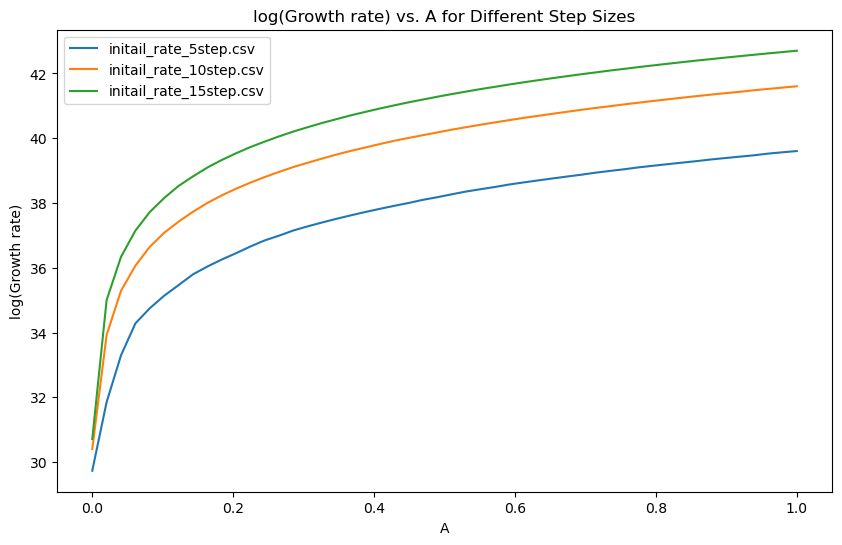

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the directory containing the files
file_directory = 'D:\\Desktop\\code\\PiC-Code-Jax\\new\\'

# List of file names
file_names = ['initail_rate_5step.csv', 'initail_rate_10step.csv', 'initail_rate_15step.csv']

# Initialize the plot
plt.figure(figsize=(10, 6))

# Iterate over each file
for file_name in file_names:
    file_path = os.path.join(file_directory, file_name)
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Plot the data
        plt.plot(df['A'], np.log(df['growth']), label=file_name)
    else:
        print(f"File {file_path} does not exist.")

# Add title and labels
plt.title('log(Growth rate) vs. A for Different Step Sizes')
plt.xlabel('A')
plt.ylabel('log(Growth rate)')
plt.legend()

# Display the plot
plt.show()
